In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
import pyramid 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
File_name = 'HS01DataCummulativeNonZeros.csv'
Variable = 'Gas Volume'

In [3]:
Well = pd.read_csv(File_name)
Gas_Volume = Well[['Time (Days)', Variable]]
Gas_Volume.to_csv("Gas_Volume.csv")

In [4]:
Gas_Volume.head()

,Time (Days),Gas Volume
0,1/1/00,4.45783
1,1/2/00,10.23198
2,1/3/00,11.90695
3,1/4/00,11.73224
4,1/5/00,10.88005


In [5]:
Gas_Volume.describe()

,Gas Volume
count,4012.000000
mean,0.529494
std,0.925229
min,0.005930
25%,0.146138
50%,0.242810
75%,0.486592
max,11.906950


In [6]:
Gas_Volume.describe(include='O')

,Time (Days)
count,4012
unique,4012
top,1/1/00
freq,1


In [7]:
print('Time period start: {}\nTime period end: {}'.format(Gas_Volume['Time (Days)'].min(),Gas_Volume['Time (Days)'].max()))

Time period start: 1/1/00
Time period end: 9/9/10


In [8]:
Gas_Volume.columns

Index(['Time (Days)', 'Gas Volume'], dtype='object')

In [9]:
Gas_Volume.shape

(4012, 2)

# Data Preprocessing and Visualization

In [10]:
Gas_Volume = pd.read_csv('Gas_Volume.csv', parse_dates=['Time (Days)'])
Gas_Volume.head()

,Unnamed: 0,Time (Days),Gas Volume
0,0,2000-01-01,4.45783
1,1,2000-01-02,10.23198
2,2,2000-01-03,11.90695
3,3,2000-01-04,11.73224
4,4,2000-01-05,10.88005


In [11]:
Gas_Volume.index

RangeIndex(start=0, stop=4012, step=1)

In [12]:
Gas_Volume.isnull().sum()

Unnamed: 0     0
Time (Days)    0
Gas Volume     0
dtype: int64

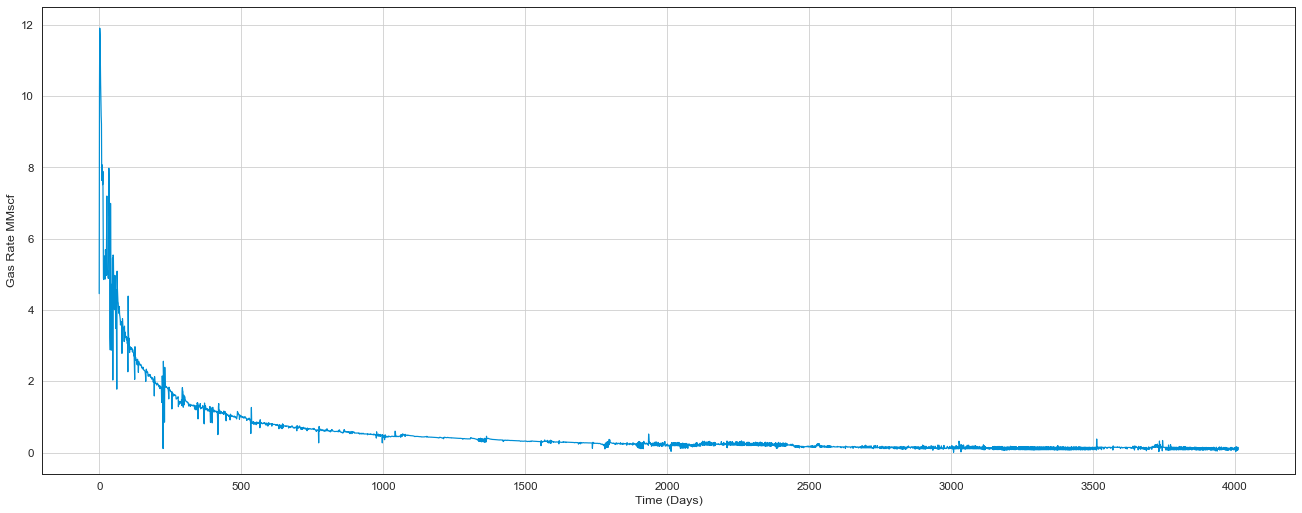

In [13]:
Gas_Volume[Variable].plot(figsize=(20, 8))
plt.xlabel('Time (Days)')
plt.ylabel('Gas Rate MMscf')
plt.grid()
plt.savefig('HS01 Curve.png')
plt.show()

### Reviewing plots of the density of observations can provide further insight into the structure of the data:
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

""""
pyplot.figure(1)
pyplot.subplot(211)
Gas_Volume[Variable].hist()
pyplot.subplot(212)
Gas_Volume[Variable].plot(kind='kde')
plt.grid()
pyplot.show()

fig.savefig('DensityOfObservationsHS01.png')
""""

##  Decomposing using statsmodel:

- We can use statsmodels to perform a decomposition of this time series.
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

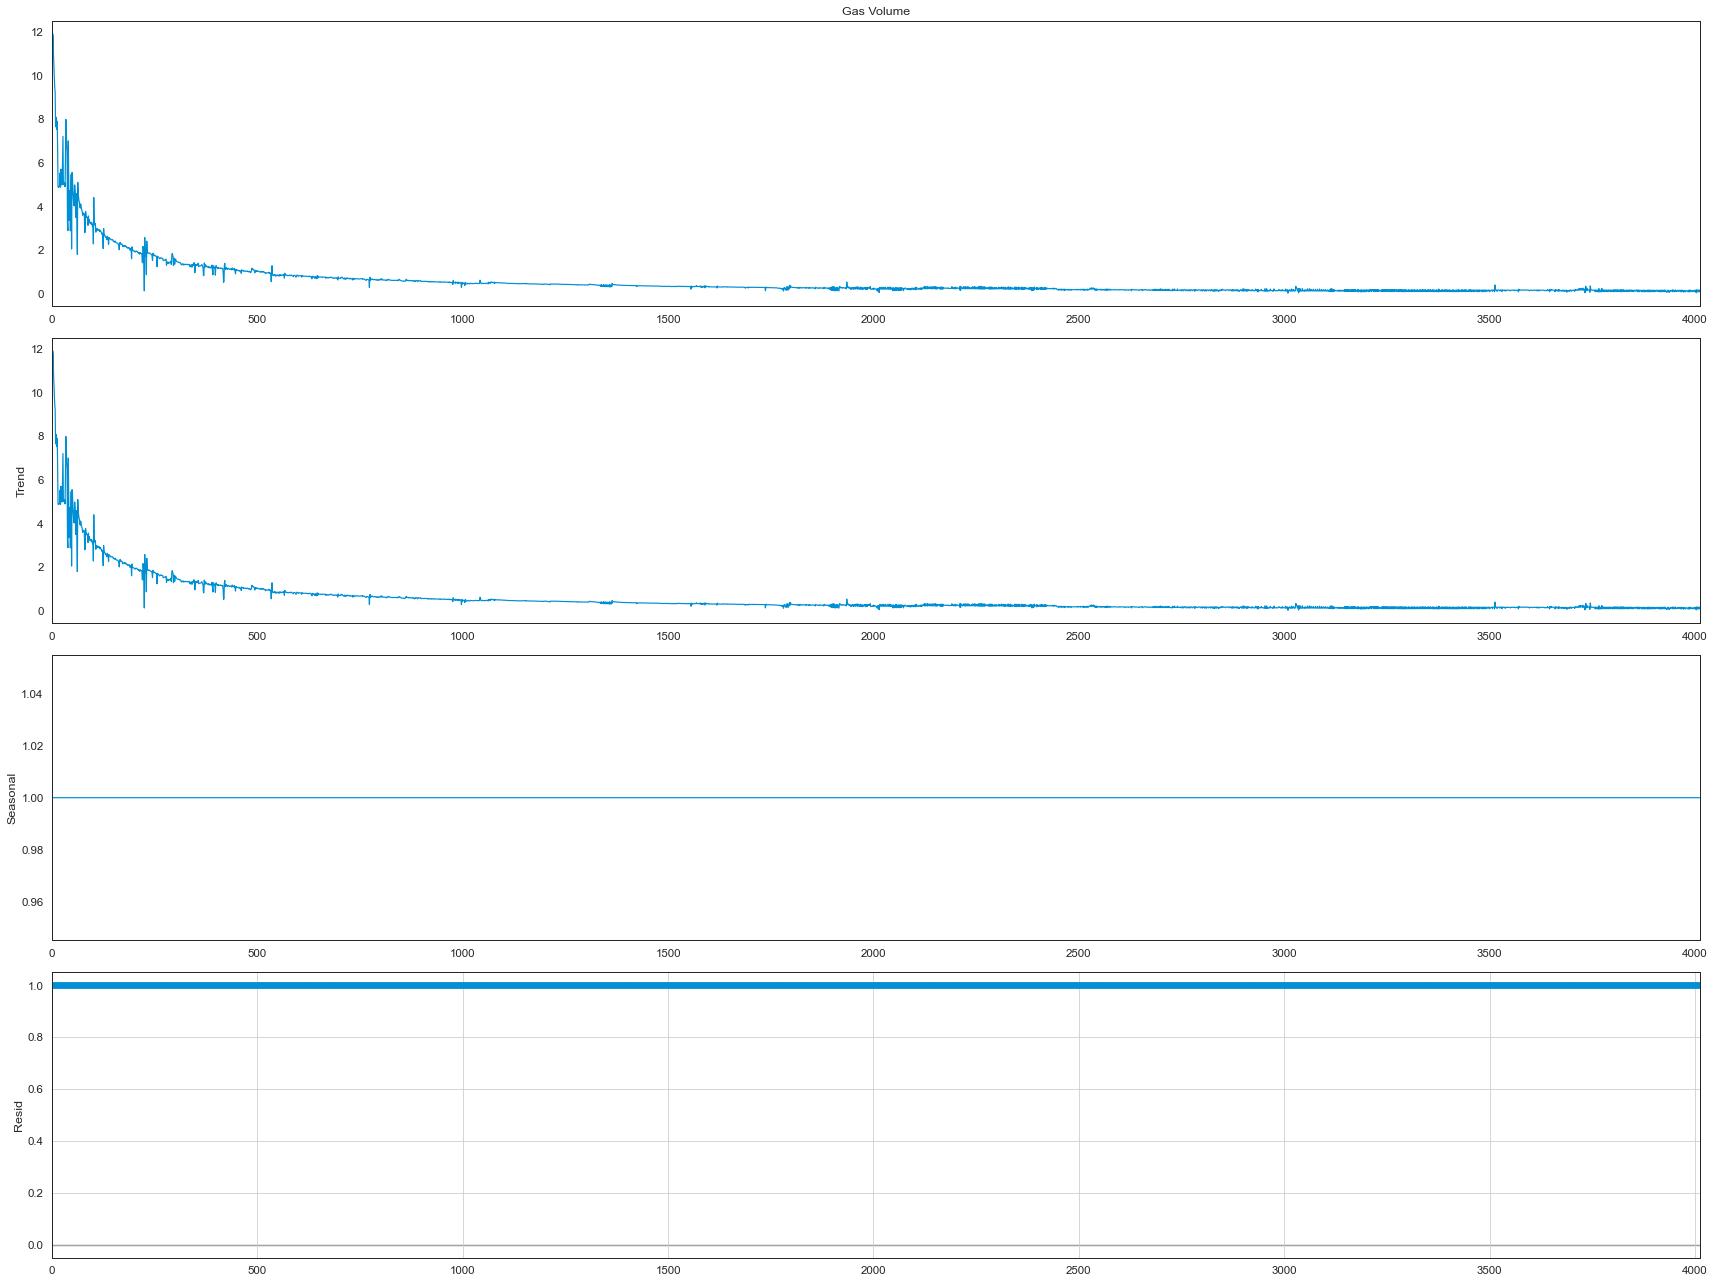

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 24, 18
decomposition = sm.tsa.seasonal_decompose(Gas_Volume[Variable], period = 1 ,model='multiplicatif')
fig = decomposition.plot()
plt.grid()
plt.savefig('DecompositionOfTheTimeSerieHS01.png')
plt.show()

## Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

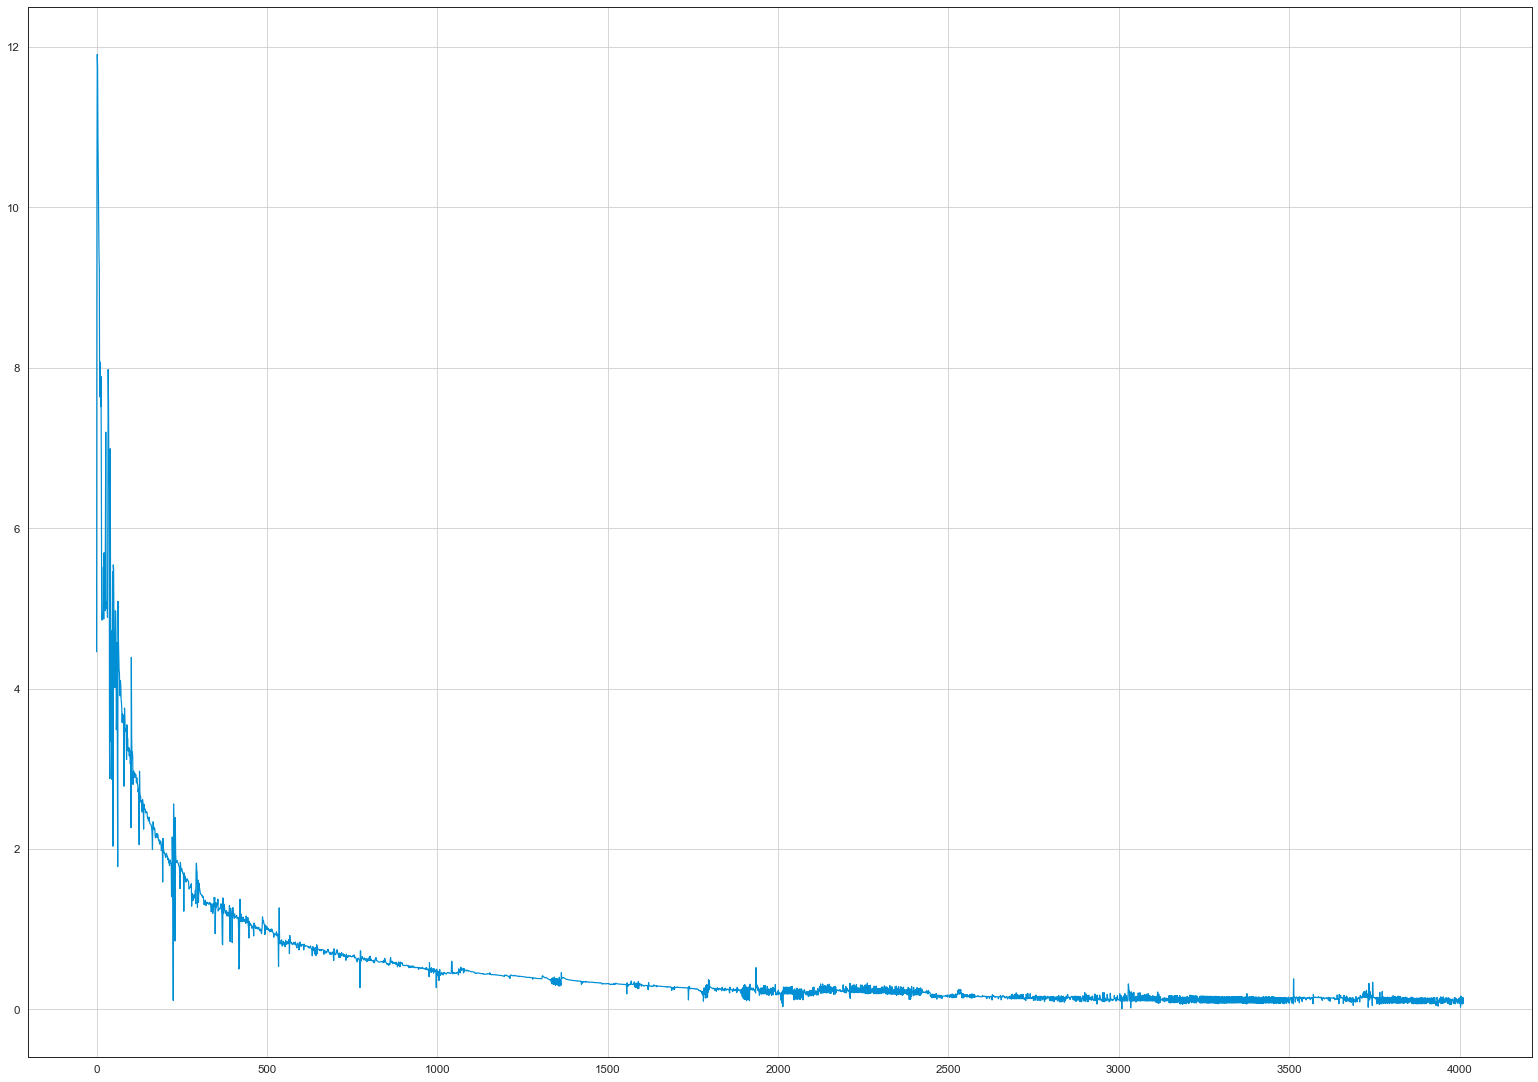

In [15]:
plt.plot(Gas_Volume[Variable])
plt.grid()

### We can check stationarity using the following:

- ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.


### ACF and PACF plots
- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone.
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

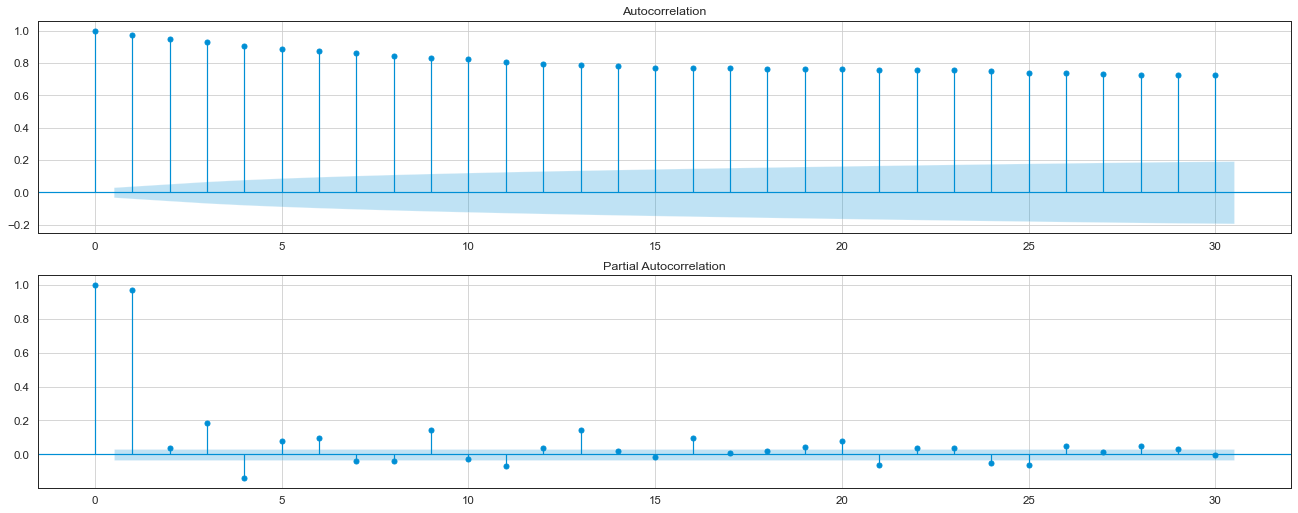

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import Series
from matplotlib import pyplot

pyplot.figure(figsize=(20, 8))
pyplot.subplot(211)
pyplot.grid()
plot_acf(Gas_Volume[Variable], ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
pyplot.grid()
plot_pacf(Gas_Volume[Variable], ax=pyplot.gca(), lags = 30)

plt.savefig('ACFPPACFBeforDerivationHS01.png')
pyplot.show()


### ACF
is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values.

### PACF
PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

## Plotting Rolling Statistics¶
- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

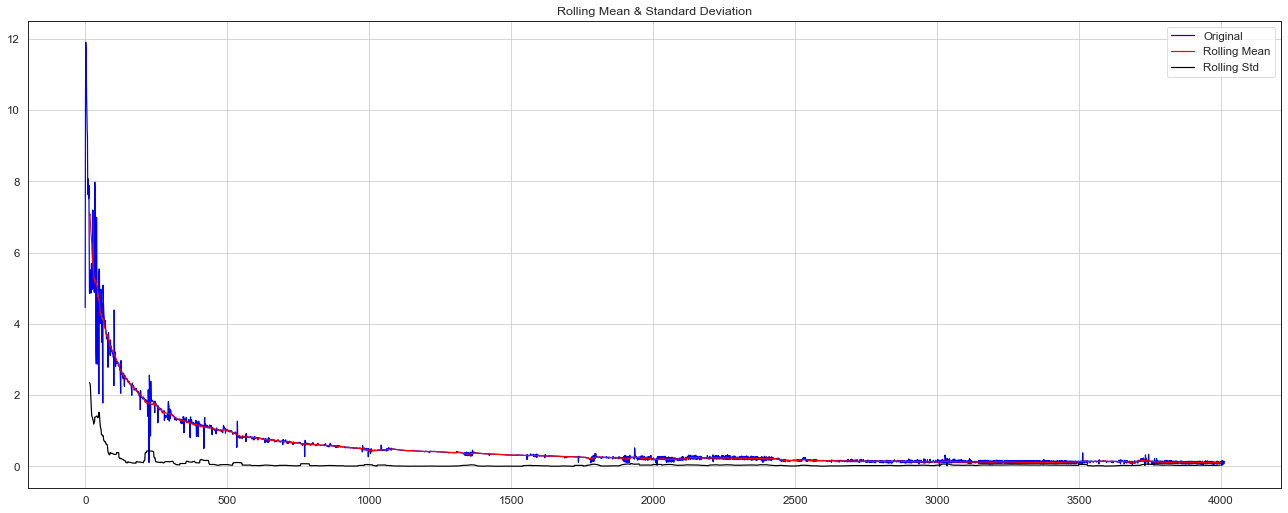

In [17]:
#Determing rolling statistics we use '30' monthly rolling to calculate the mean and the standard derivation
rolmean = Gas_Volume[Variable].rolling(30, center=True, closed='both').mean()
rolstd = Gas_Volume[Variable].rolling(30, center=True, closed='both').std()

#Plot rolling statistics:
plt.figure(figsize=(20, 8))
orig = plt.plot(Gas_Volume[Variable], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.grid()

plt.savefig('RollingMean&StandardDeviationHS01.png')
plt.show(block=False)

## Augmented Dickey-Fuller Test¶

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(Gas_Volume[Variable], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -24.212649
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    3980.000000
Critical Value (1%)              -3.431994
Critical Value (5%)              -2.862266
Critical Value (10%)             -2.567157
dtype: float64


In [20]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30, center=True, closed='both').mean()
    rolstd = timeseries.rolling(30, center=True, closed='both').std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# ARIMA

In [21]:
Well = pd.read_csv(File_name)
Gas_Volume = Well[['Time (Days)',Variable]]
Gas_Volume.to_csv("Gas_Volume.csv")

In [22]:
Gas_Volume.head()

,Time (Days),Gas Volume
0,1/1/00,4.45783
1,1/2/00,10.23198
2,1/3/00,11.90695
3,1/4/00,11.73224
4,1/5/00,10.88005


In [23]:
# Convert days into Datetime
Gas_Volume['Time (Days)']=pd.to_datetime(Gas_Volume['Time (Days)'])

In [24]:
Gas_Volume.head()

,Time (Days),Gas Volume
0,2000-01-01,4.45783
1,2000-01-02,10.23198
2,2000-01-03,11.90695
3,2000-01-04,11.73224
4,2000-01-05,10.88005


In [25]:
Gas_Volume.set_index('Time (Days)',inplace=True)


In [26]:
Gas_Volume.head()

,Gas Volume
Time (Days),
2000-01-01,4.45783
2000-01-02,10.23198
2000-01-03,11.90695
2000-01-04,11.73224
2000-01-05,10.88005


In [27]:
Gas_Volume.describe()

,Gas Volume
count,4012.000000
mean,0.529494
std,0.925229
min,0.005930
25%,0.146138
50%,0.242810
75%,0.486592
max,11.906950


## Visualization

In [28]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(Gas_Volume[Variable])

In [29]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Variable):
    result=adfuller(Variable)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [30]:
adfuller_test(Gas_Volume[Variable])

ADF Test Statistic : -24.212648674982166
p-value : 0.0
#Lags Used : 31
Number of Observations Used : 3980
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Differencing

In [31]:
Gas_Volume['Gas Volume First Difference'] = Gas_Volume[Variable] - Gas_Volume[Variable].shift(1)

In [32]:
Gas_Volume[Variable].shift(1)

Time (Days)
2000-01-01         NaN
2000-01-02     4.45783
2000-01-03    10.23198
2000-01-04    11.90695
2000-01-05    11.73224
                ...   
2011-01-09     0.07072
2011-01-10     0.14167
2011-01-11     0.06459
2011-01-12     0.14653
2011-01-13     0.06990
Name: Gas Volume, Length: 4012, dtype: float64

In [33]:
## Again test dickey fuller test
adfuller_test(Gas_Volume['Gas Volume First Difference'].dropna())

ADF Test Statistic : -18.04045726530029
p-value : 2.6587592457352785e-30
#Lags Used : 31
Number of Observations Used : 3979
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


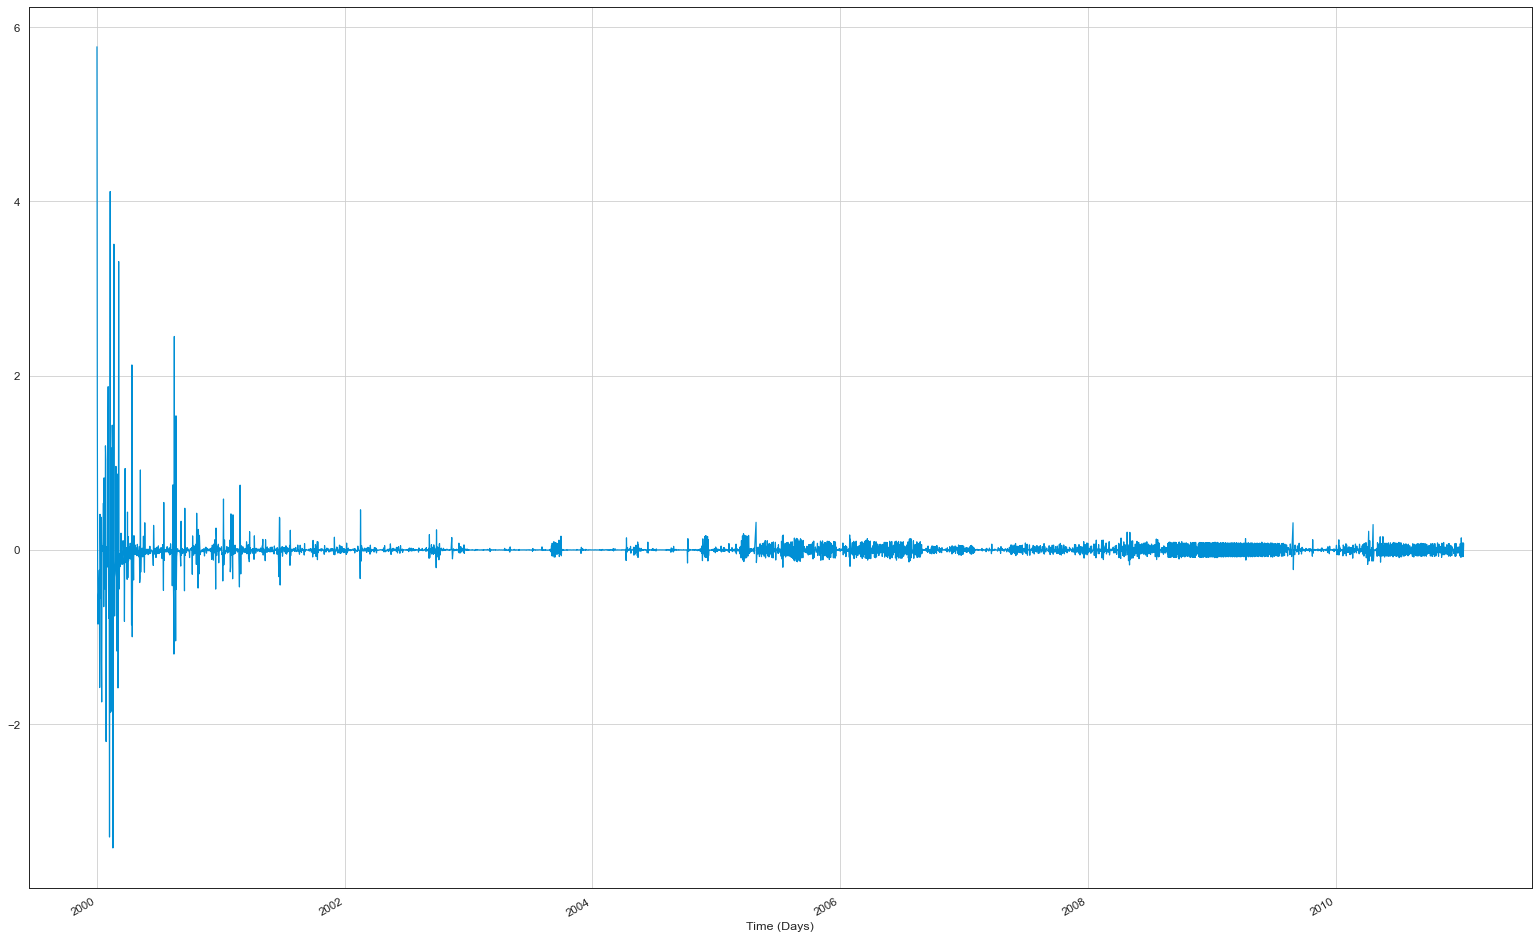

In [34]:
Gas_Volume['Gas Volume First Difference'].plot()
plt.grid()
plt.savefig('AfterFirstDerivationHS01.png')

### Auto Regressive Model

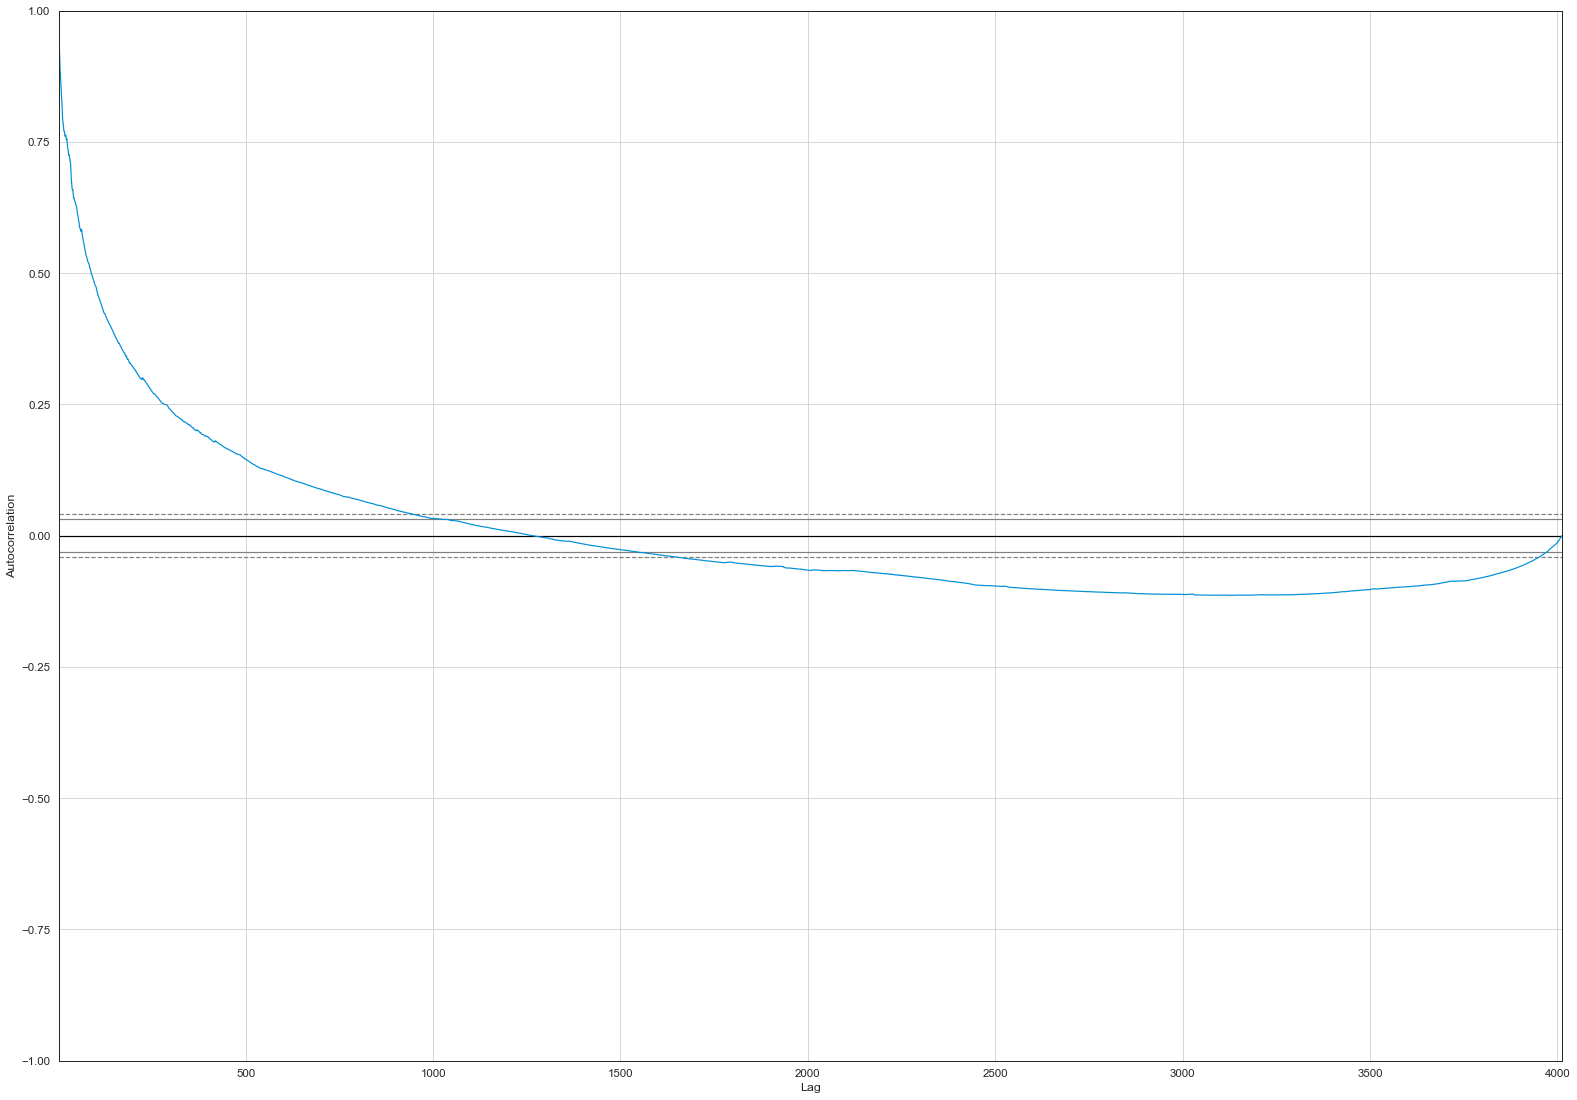

In [35]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Gas_Volume[Variable])
plt.savefig('AutoCorrelationPlotHS01.png')
plt.show()

## Final Thoughts on Autocorrelation and Partial Autocorrelation
- Identification of an AR model is often best done with the PACF.
* For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
- Identification of an MA model is often best done with the ACF rather than the PACF.

* For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

* p,d,q p AR model lags d differencing q MA lags

In [36]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

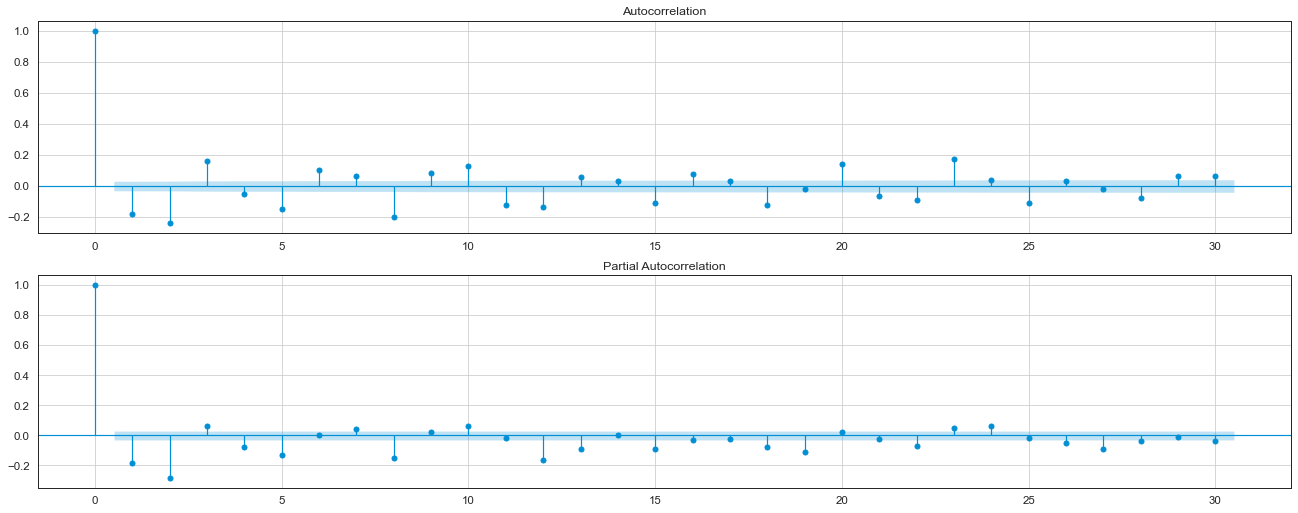

In [37]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
plt.grid()
fig = sm.graphics.tsa.plot_acf(Gas_Volume['Gas Volume First Difference'].iloc[1:],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
plt.grid()
fig = sm.graphics.tsa.plot_pacf(Gas_Volume['Gas Volume First Difference'].iloc[1:],lags=30,ax=ax2)

fig.savefig('ACFPACFAfterHS01.png')

In [38]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [39]:
model=ARIMA(Gas_Volume[Variable],order=(1,1,1))
model_fit=model.fit()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.95540D-01    |proj g|=  1.02829D-01

At iterate    5    f= -2.02366D-01    |proj g|=  1.79282D-01

At iterate   10    f= -2.05768D-01    |proj g|=  3.36617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   2.220D-08  -2.058D-01
  F = -0.20576835549012229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Gas Volume   No. Observations:                 4011
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 825.337
Method:                       css-mle   S.D. of innovations              0.197
Date:                Sun, 19 Sep 2021   AIC                          -1642.674
Time:                        23:24:43   BIC                          -1617.487
Sample:                             1   HQIC                         -1633.747
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0020      0.001     -2.216      0.027      -0.004      -0.000
ar.L1.D.Gas Volume     0.4039      0.031     12.998      0.000       0.343       0.465
ma.L1.D.Gas Volume    -0.8234      0.018    -45.885      0.000      -0.859      -0.788
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4758           +0.0000j            2.4758            0.0000
MA.1            1.2144           +0.0000j            1.2144            0.0000
-----------------------------------------------------------------------------
"""

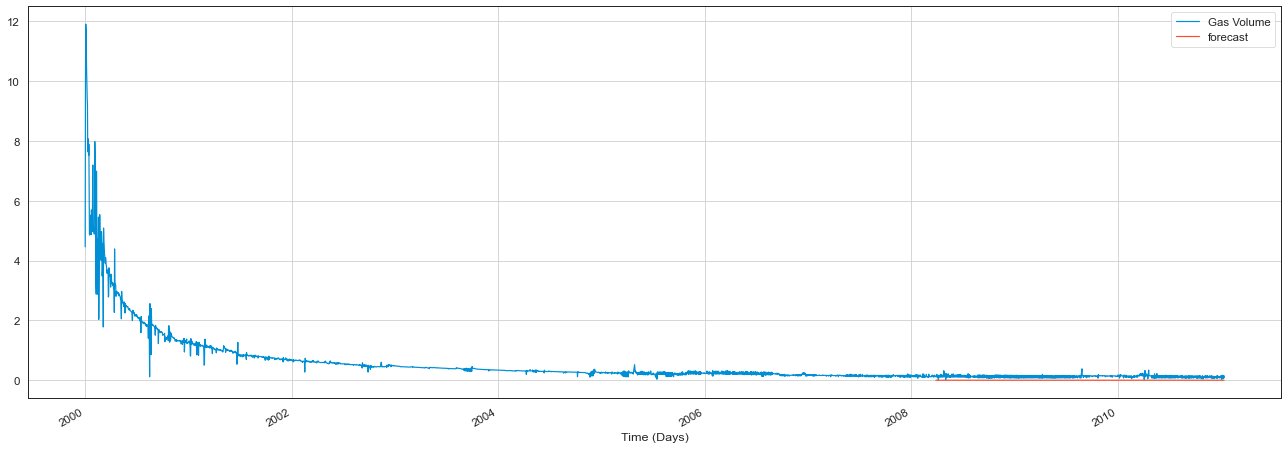

In [41]:
Gas_Volume['forecast']=model_fit.predict(start=3000,end=4011,dynamic=True)
Gas_Volume[[Variable,'forecast']].plot(figsize=(20,8))
plt.grid()

In [42]:
import statsmodels.api as sm

In [43]:
model=sm.tsa.statespace.SARIMAX(Gas_Volume[Variable],order=(1, 1, 1),seasonal_order=(1,1,1,2))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35434D-02    |proj g|=  1.46248D+00

At iterate    5    f= -1.48867D-01    |proj g|=  3.06394D-01

At iterate   10    f= -2.16610D-01    |proj g|=  1.97664D-02

At iterate   15    f= -2.19062D-01    |proj g|=  3.90266D-03

At iterate   20    f= -2.19063D-01    |proj g|=  1.04759D-03

At iterate   25    f= -2.19077D-01    |proj g|=  2.94565D-03

At iterate   30    f= -2.19100D-01    |proj g|=  2.25799D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

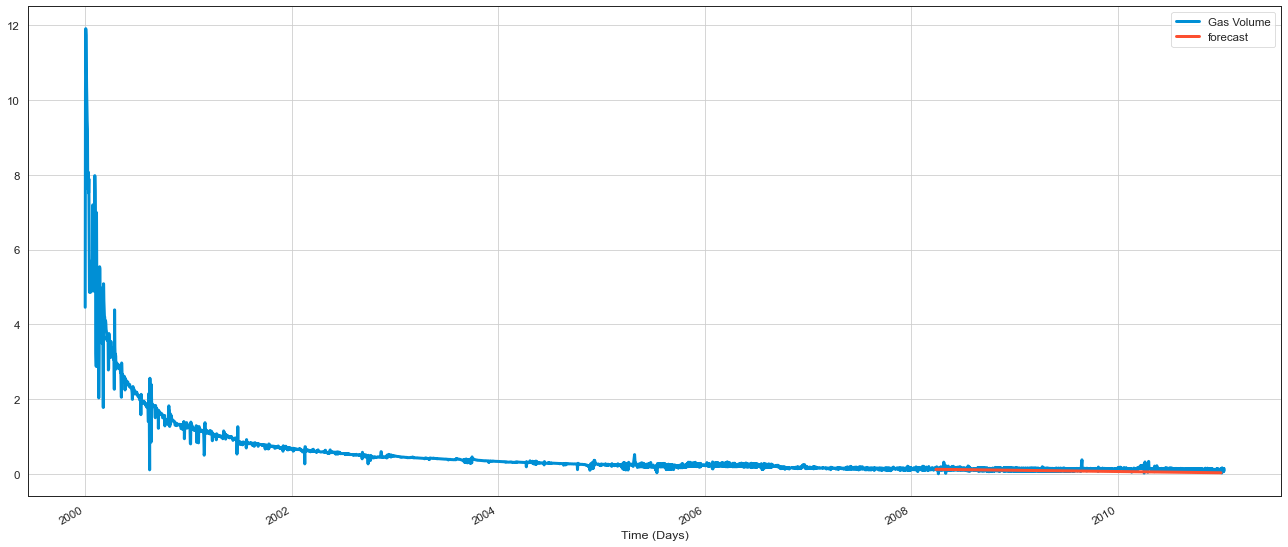

In [44]:
Gas_Volume['forecast']=results.predict(start=3000,end=4000,dynamic=True)
Gas_Volume[[Variable,'forecast']].plot(figsize=(20,10) ,linewidth=3)
plt.grid()

plt.savefig('ActualVsForecastSARMIAHS01.png')

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
Gas_Volume.head()

,Gas Volume,Gas Volume First Difference,forecast
Time (Days),,,
2000-01-01,4.45783,NaN,NaN
2000-01-02,10.23198,5.77415,NaN
2000-01-03,11.90695,1.67497,NaN
2000-01-04,11.73224,-0.17471,NaN
2000-01-05,10.88005,-0.85219,NaN


In [47]:
Gas_Volume_Forecasted = Gas_Volume.copy()

In [48]:
Gas_Volume_Forecasted = Gas_Volume_Forecasted.drop(['Gas Volume First Difference'], axis=1)

In [49]:
Gas_Volume_Forecasted = Gas_Volume_Forecasted.dropna()
Gas_Volume_Forecasted

,Gas Volume,forecast
Time (Days),,
2008-03-29,0.11729,0.120144
2008-03-30,0.12098,0.124919
2008-03-31,0.11821,0.124012
2008-04-01,0.19341,0.125141
2008-04-02,0.10362,0.124174
...,...,...
2010-12-29,0.09387,0.032449
2010-12-30,0.12810,0.033546
2010-12-31,0.12936,0.032264


In [50]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [51]:
print(evaluate_forecast(Gas_Volume_Forecasted[Variable], Gas_Volume_Forecasted['forecast']))

   r2_score  mean_absolute_error  median_absolute_error       mse      msle       mape      rmse
0 -1.846859             0.052885               0.057898  0.004038  0.003268  42.461275  0.063545
